<a href="https://colab.research.google.com/github/corerage/Hamoye/blob/main/Stage_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from google.colab import files

In [7]:
uploaded = files.upload()


Saving Time_series_analysis_and_forecast_DATASET.csv to Time_series_analysis_and_forecast_DATASET (1).csv


In [8]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Time_series_analysis_and_forecast_DATASET.csv']))

In [9]:
df

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.21500,3.6900,23.710
1,2010-09-01 01:00:00,15.8,1669.19500,3.6900,22.635
2,2010-09-01 02:00:00,15.8,1491.98000,3.6900,22.565
3,2010-09-01 03:00:00,15.8,1330.76000,3.6900,18.910
4,2010-09-01 04:00:00,15.8,1247.94000,3.6900,18.030
...,...,...,...,...,...
92011,2021-02-28 19:00:00,24.3,449.63625,5.4848,117.925
92012,2021-02-28 20:00:00,24.3,815.59975,5.4848,87.880
92013,2021-02-28 21:00:00,24.3,745.12325,5.4848,62.060
92014,2021-02-28 22:00:00,24.3,694.95150,5.4848,62.000


In [10]:
import io, os, sys, setuptools, tokenize

In [11]:
!pip install prophet
import prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
df.isnull().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [13]:
df.describe()


,Tmax,SysLoad,GasPrice,ElecPrice
count,92016.000000,92016.000000,92016.000000,92016.000000
mean,231.696688,797.623357,6.016163,65.798356
std,4562.128748,613.520156,2.608116,213.144084
min,9.900000,-1596.810100,0.000000,-924.820000
25%,17.300000,417.119800,3.936900,31.543750
50%,21.900000,856.467925,5.165600,48.715000
75%,27.600000,1221.293675,8.023300,76.495000
max,99999.900000,3264.166300,29.990000,14700.000000


In [14]:
# Convert to a time series object - 'FullDate' to 'DateTime' 
from datetime import datetime
df['FullDate'] = pd.to_datetime(df.FullDate)

# Rename the Columns FullDate And ElecPrice
df = df.rename(columns={"FullDate" : "ds" , "ElecPrice" : "y" }) 
df.set_index('ds', inplace=True)
df.head()

,Tmax,SysLoad,GasPrice,y
ds,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [15]:
# Resampling from Hourly to Daily data points
df_daily = df.resample('D').sum()

In [16]:
df_daily.corr()

,Tmax,SysLoad,GasPrice,y
Tmax,1.000000,-0.012249,0.030173,0.004748
SysLoad,-0.012249,1.000000,-0.268321,0.170524
GasPrice,0.030173,-0.268321,1.000000,0.352420
y,0.004748,0.170524,0.352420,1.000000


In [17]:
# Looking at the shape of Daily Rate
df_daily.shape

(3834, 4)

Text(0, 0.5, 'ElecPrice')

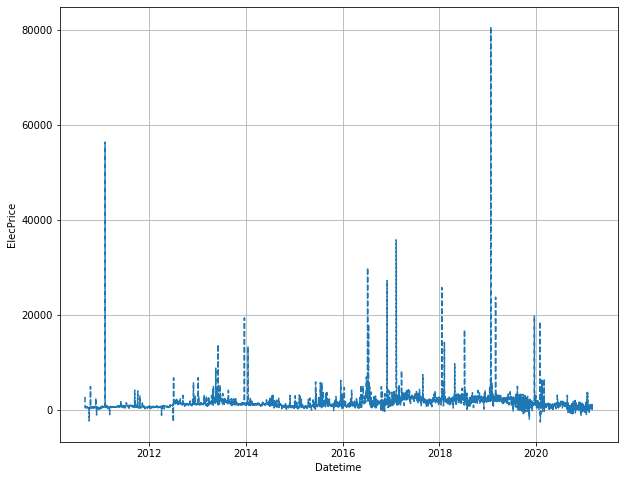

In [18]:
#plot of the daily global_active_power over time
plt.figure(figsize=(10,8))
plt.plot(df_daily.index, df_daily.y, '--')
plt.grid()
plt.xlabel('Datetime')
plt.ylabel('ElecPrice')

In [19]:
#Importing the ADF library
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

adf_sysload = adfuller(df_daily['SysLoad'])
adf_gasprice = adfuller(df_daily['GasPrice'])
print(f'p-value of the SysLoad: {round(adf_sysload[1],6)}')
print(f'p-value of the GasPrice: {round(adf_gasprice[1],6)}')

p-value of the SysLoad: 0.004254
p-value of the GasPrice: 0.045027


In [20]:
# Critical Values of GasPrice
adf_gasprice = adfuller(df_daily['GasPrice'])
print(f'ADF Statistic: {round(adf_gasprice[0],4)}')
print('Critical Values:')
for k, v in adf_gasprice[4].items():
  print(f'   {k}: {v}')

ADF Statistic: -2.9028
Critical Values:
   1%: -3.4320693157877544
   5%: -2.8622996992165364
   10%: -2.5671743978048323


In [21]:
# Critical Values of ElecPrice
adf_elecprice = adfuller(df_daily['y'])
print(f'ADF Statistic: {round(adf_elecprice[0],4)}')
print('Critical Values:')

for k, v in adf_elecprice[4].items():
 print(f'{k} : {v}') 

ADF Statistic: -8.2691
Critical Values:
1% : -3.432066157296446
5% : -2.8622983040036005
10% : -2.5671736550459663


In [22]:
# Rest the index
df_daily.reset_index(inplace=True)

In [23]:
#Split the dataset
train = df_daily.iloc[:2757,:]
test = df_daily.iloc[2757:,:]

In [24]:
train.shape

(2757, 5)

In [25]:
train.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [26]:
# Defining the MAPE function
def mape(y, yhat):
  y = y.reset_index(drop=True)
  return round(np.mean(np.abs((y - yhat)/y)*100),2)

In [29]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9536782 sha256=114c1424b9023d8b1c6c4a07f2cd60fe71ebbd064bfb936fbe30fd00e5aeee7d
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdsta

In [30]:
from fbprophet import Prophet
# fit train data to fb prophet model
model_1 = Prophet()
model_1.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
pred = model_1.predict(test) 
mape(test['y'],pred['yhat'])

544.76

In [32]:
# Defining the RMSE function
def rmse(y, yhat):
  y = y.reset_index(drop=True)
  return round(np.sqrt(np.mean(np.square(y - yhat))),2)

In [34]:
rmse(test['y'], pred['yhat'])

3208.17

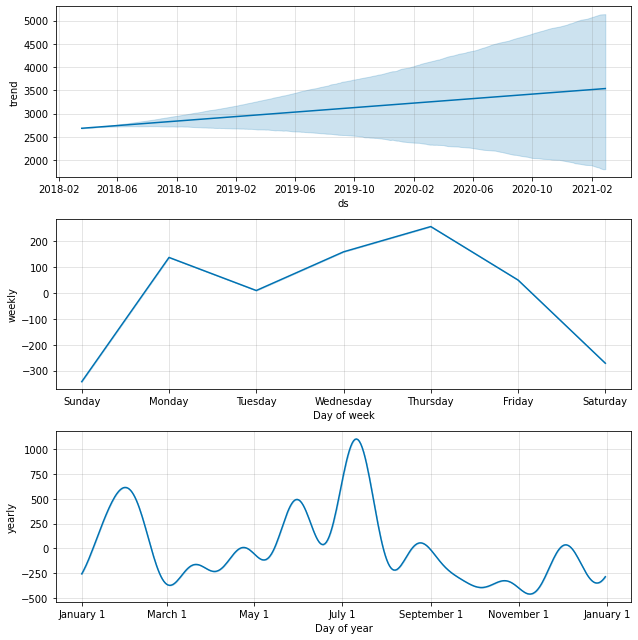

In [35]:
model_1.plot_components(pred) 
plt.show()

In [36]:
#Rename "SysLoad", "Tmax", and "GasPrice" to "add1", "add2", and "add3" respectively
new_df = df_daily.rename(columns={"SysLoad" : "add1" , "Tmax" : "add2", "GasPrice" : "add3" })
new_df.head()

,ds,add2,add1,add3,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [37]:
# assign train and test data
train2 = new_df[:2757]
test2 = new_df[2757:]
print('train shape', train2.shape)
print('test shape', test2.shape)

train shape (2757, 5)
test shape (1077, 5)


In [38]:
#Create multivariate model
model2 = Prophet()

model2.add_regressor('add1')
model2.add_regressor('add2')
model2.add_regressor('add3')

In [39]:
model2.fit(train2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
#Evaluate MAPE on the test set
pred = model2.predict(test2) 
mape(test['y'],pred['yhat'])

232.84

In [41]:
#RMSE on test set
rmse(test2['y'],pred['yhat'])

2708.6

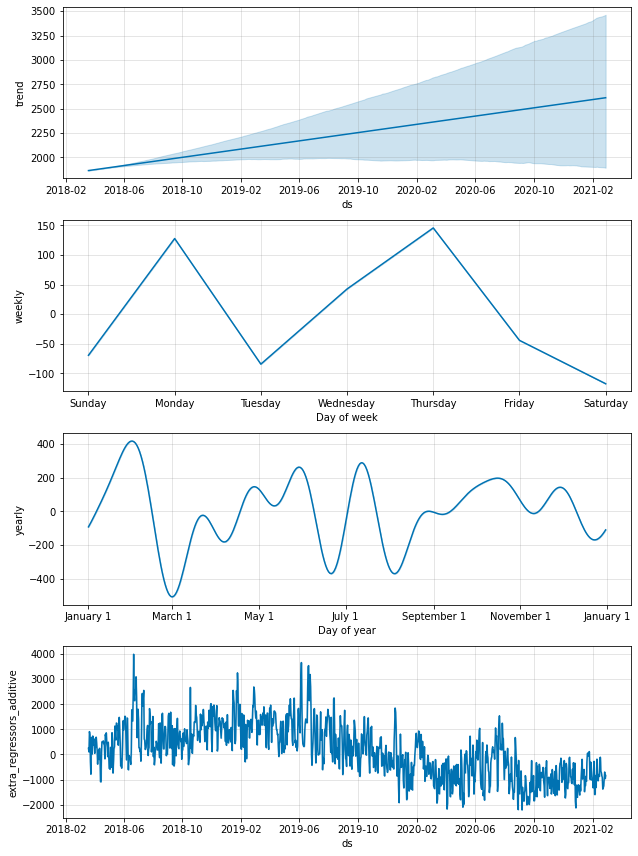

In [42]:
model2.plot_components(pred) 
plt.show()

In [43]:
# Split the dataset
train3 = new_df.iloc[:2757,:]
test3 = new_df.iloc[2757:,:]
train3.shape , test3.shape

((2757, 5), (1077, 5))

In [44]:
#Training a forecast model without 'Tmax' 
model_3 = Prophet()
model_3.add_regressor('add1')
model_3.add_regressor('add3')

In [45]:
model_3.fit(train3)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
pred = model_3.predict(test3) 
mape(test3['y'],pred['yhat'])

233.86

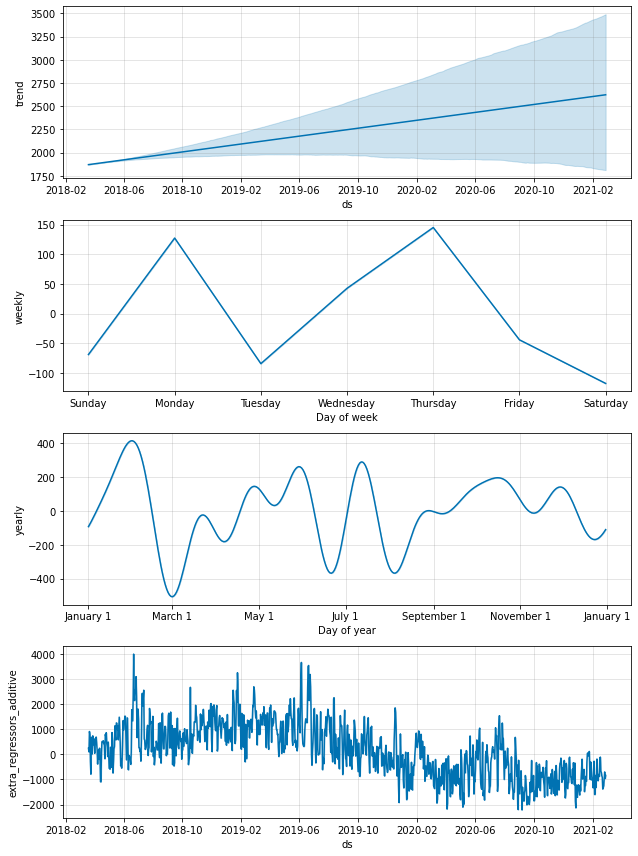

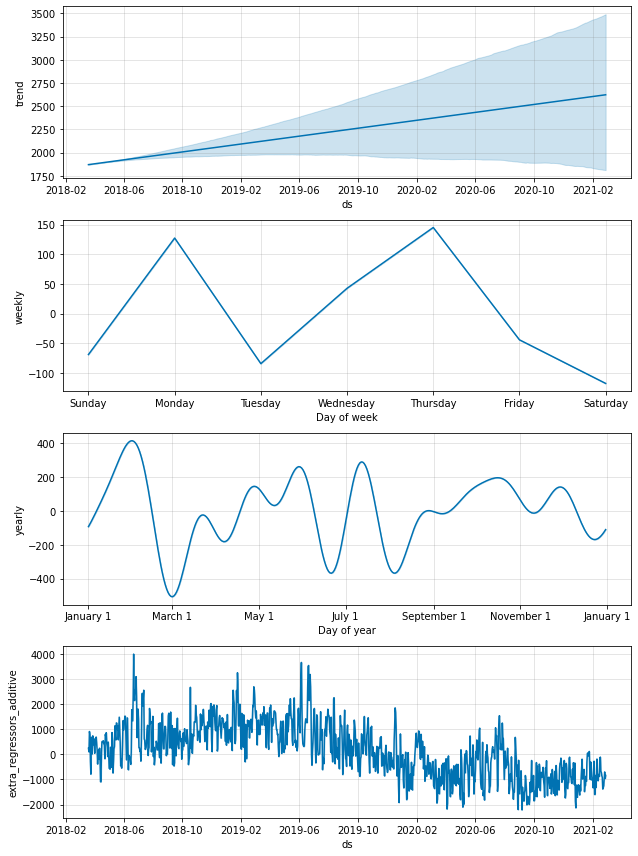

In [47]:
model_3.plot_components(pred)


In [ ]:
w  